In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from operator import attrgetter
from scipy import stats
from scipy.stats import levene
from scipy.stats import norm

# Визуализация 

import seaborn as sns
sns.set(rc={"figure.figsize":(12,8)})
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

- В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

- Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

- Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.


## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.



#### Функция для расчета retention rate

Функция принимает 3 значения на входе:

- Начало даты расчета
- Конец даты расчета
- Тип расчета когорт 'D' - в днях, 'M' - в месяцах

Дату начала расчета следует писать в unix исчислении дат для ускорения расчетов.

Для конвертизации с даты на unix - https://www.epochconverter.com/

In [2]:
retention = {}  
retention = pd.DataFrame(retention)  
path_to_reg_csv  =  '/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-makarov/shared/problem1-reg_data.csv' #введите путь до файла csv с данными регистраций
path_to_auth_csv =  '/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-makarov/shared/problem1-auth_data.csv'

def get_retention(date_start, date_end, cohort_type):
    
    # задаем время старта и конца
    date_start = date_start
    date_end   = date_end
    cohort_type = cohort_type
    
    reg  = pd.read_csv(path_to_reg_csv,  sep = ';')
    auth = pd.read_csv(path_to_auth_csv, sep = ';')

    auth = auth.query('auth_ts <= {}'.format(date_end)) # отбирает даты с указанной в date_unix_query
    auth = auth.query('auth_ts >= {}'.format(date_start))
    reg  = reg.query ('reg_ts >=  {}'.format(date_start))
    reg  = reg.query ('reg_ts <=  {}'.format(date_end))


    df = auth.merge(reg, how = 'left', on = 'uid') # соединим наши таблицы по id ключу

    #date - меняем с даты c unix на год-месяц
    df['reg_date']   =  pd.to_datetime(df.reg_ts, unit='s').dt.to_period ((cohort_type))
    df['auth_date']  =  pd.to_datetime(df.auth_ts, unit='s').dt.to_period((cohort_type))
    df = pd.DataFrame(df) 

    #cohort присваиваем когорты с даты регистрации
    df['cohort']     =  df.groupby('uid')['reg_date'].transform('min')
    cohort           =  df.groupby(['cohort', 'auth_date']) \
                                    .agg({'uid': pd.Series.nunique}) \
                                    .rename(columns={'uid': 'count_customers'}) \
                                    .reset_index()
    cohort['cohort_group'] = (cohort.auth_date - cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = cohort.pivot_table(index='cohort', columns='cohort_group', values='count_customers')

    #считаем retention rate
    cohort_size = cohort_pivot.iloc[:,0]
    retention   = cohort_pivot.divide(cohort_size, axis = 0).mul(100).round(2)
    retention   = retention.iloc[:,1:]
    
    
    sns.heatmap(retention, annot=True) # график в процентах
    retention
    return retention, cohort_pivot

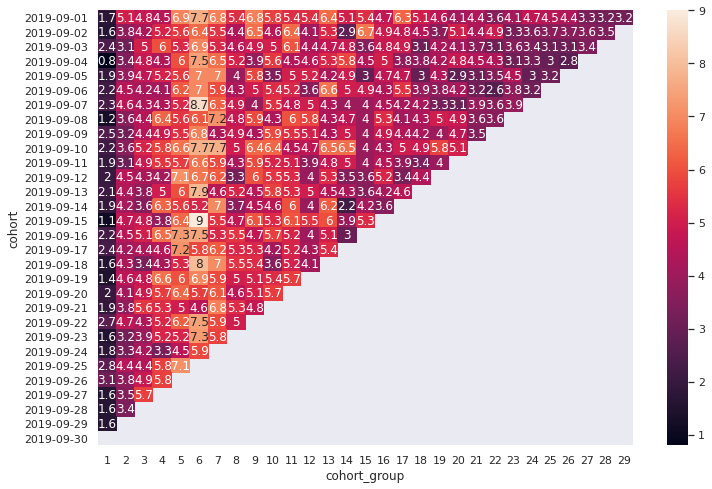

In [3]:
retention = get_retention(1567296000, 1569888000, 'D')

In [4]:
retention

(cohort_group    1     2     3     4     5     6     7     8     9     10  ...  \
 cohort                                                                    ...   
 2019-09-01    1.73  5.06  4.83  4.49  6.90  7.71  6.79  5.41  6.79  5.75  ...   
 2019-09-02    1.61  3.79  4.25  5.17  5.63  6.44  5.52  4.37  6.55  4.60  ...   
 2019-09-03    2.41  3.10  5.05  5.97  5.28  6.89  5.28  4.59  4.94  5.05  ...   
 2019-09-04    0.80  3.44  4.81  4.35  5.96  7.45  6.53  5.15  3.89  5.61  ...   
 2019-09-05    1.95  3.89  4.69  5.15  5.61  6.98  6.98  4.00  5.84  3.55  ...   
 2019-09-06    2.17  4.45  4.22  4.11  6.16  6.96  5.94  4.34  5.02  5.37  ...   
 2019-09-07    2.28  4.56  4.33  4.33  5.25  8.67  6.27  4.90  3.99  5.47  ...   
 2019-09-08    1.25  3.64  4.44  6.37  5.57  6.14  7.17  4.78  5.92  4.32  ...   
 2019-09-09    2.50  3.18  4.43  4.89  5.45  6.82  4.32  4.89  4.32  5.91  ...   
 2019-09-10    2.16  3.63  5.22  5.79  6.58  7.72  7.72  4.99  6.36  6.36  ...   
 2019-09-11    1

---

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?



-----

## Проверка данных

In [5]:
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-an-makarov/final_project/ab_test.csv', sep = ';')

In [6]:
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [8]:
data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Пустых значений в нашем датафрейме нет

In [9]:
data.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Как можно видеть у нас очень большое std(среднеквадратическое отклонение), а квантили вообще по нулям. Можно предположить что у нас имеются очень большие выбросы в нашем датафрейме и много неплатящих игроков.

Давайте посмотрим график распределения

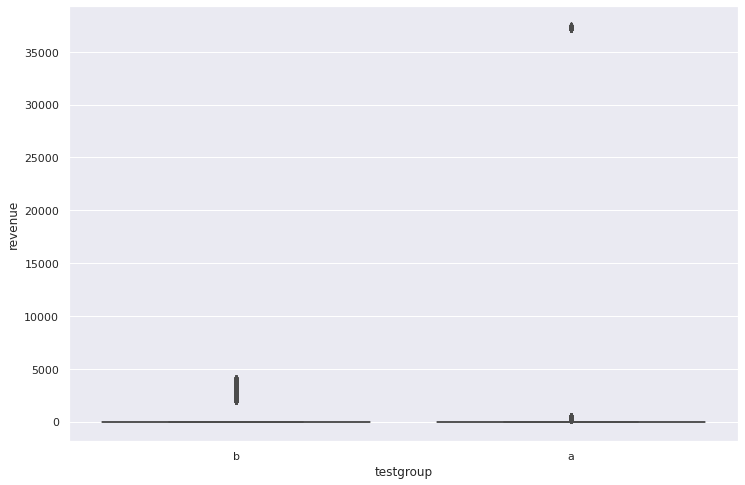

In [10]:
sns.boxplot(x='testgroup', y='revenue', data=data, palette = ["g","b"])

Исходя из графика мы имеем, что в группе A имеются очень сильные выбросы и максимальное его значение 37433. Группа B ведет себя более нормально, чем группа А.

Проверим высказывания про ARPU и конверсию в покупку из условий задачи. Для этого разделим наших пользователей по группам

In [11]:
gr_a = data[data.testgroup  == "a"]
gr_b = data[data.testgroup  == "b"]

In [12]:
display(gr_a.user_id.nunique(),gr_b.user_id.nunique())

202103

202667

В группах имеется почти одинаковое число пользователей. 

Также создадим отдельный  датафрейм с платящими пользователями и посмотрим их значения и график

In [13]:
paying_users = data.query('revenue > 0')

In [14]:
display(paying_users.query('testgroup == "b"').revenue.describe(), sum(gr_b.revenue))

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

5421603

In [15]:
display(paying_users.query('testgroup == "a"').revenue.describe(), sum(gr_a.revenue))

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

5136189

In [16]:
gr_a.query('revenue > 0')['revenue'].median(), gr_b.query('revenue > 0')['revenue'].median()

(311.0, 3022.0)

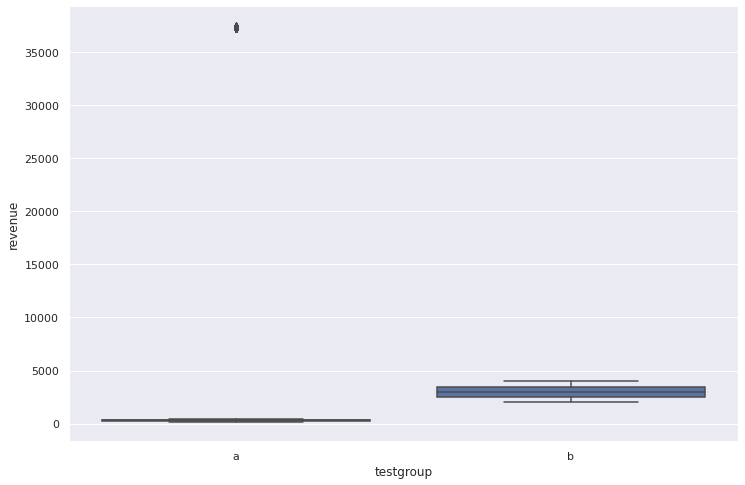

In [17]:
sns.boxplot(x='testgroup', y='revenue', data=paying_users, palette = ["g","b"])

Исходя из данных платящих игроков, можно предположить следующее: 

- В целом группа B ведет себя лучше, так как средний чек и общее Revenue больше чем у группы A на 285414
- Группа А имеет больший размах Revenue и максимальное значение достигает 37433, но квантили намного ниже чем группа B

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


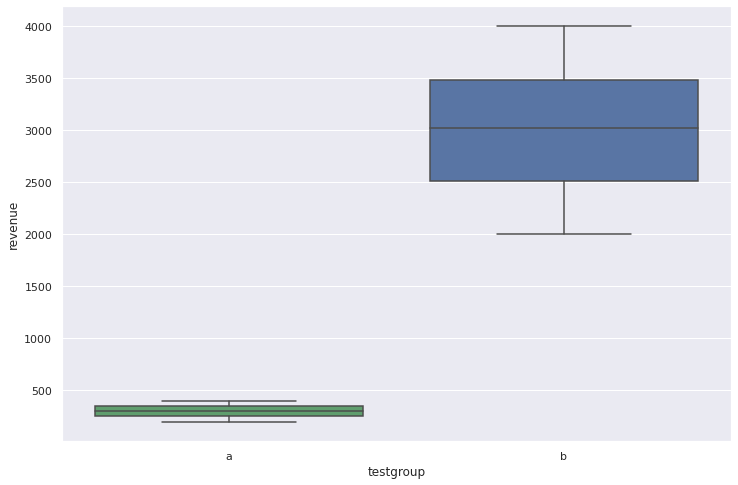

In [18]:
sns.boxplot(y='revenue', x='testgroup', data=paying_users[data['revenue'] < 10000], palette = ["g","b"])

График boxplot платящих игроков и без выбросов из группы А, показывает нам что группа В намного лучше по своим показателям.

Давайте изучим выбросы группы А

In [19]:
gr_a.query('revenue > 5000').groupby('user_id')['revenue'].value_counts().sort_values(ascending=False)

user_id  revenue
399295   37321      1
103437   37314      1
118397   37299      1
118703   37299      1
121907   37302      1
                   ..
299427   37302      1
301586   37297      1
309603   37314      1
312024   37316      1
417      37324      1
Name: revenue, Length: 123, dtype: int64

Всего 123 игроков купила на сумму 37324 что довольно много

Посмотрим на общее revenue таких игроков

In [20]:
gr_a.query('revenue > 5000')['revenue'].sum()

4590252

In [21]:
gr_a.query('revenue > 5000')['revenue'].sum()/data.revenue.sum()*100

43.47738618074688

Примерно половина общей revenue состоит из игроков китов, что очень много. 

- Предлагаю провести дополнительное исследование такого вот сегмента игроков, которые могут купить на такие суммы. Что они покупают, откуда они и.т.п. и понять это случайное аномалие или есть такой сегмент игроков
- Также возможно и то, что эти покупки были определены системой неправильно и отображается неверное revenue, так как слишком высокий выброс. Эти данные принадлежат 0.9999 процентилю. Поэтому нужно посмотреть структуру таких покупок на такую сумму. Возможно ошибка кроется в логах этих данных.

In [22]:
round(1928.000000/gr_a.shape[0],4)*100

0.95

In [23]:
round(1805.000000/gr_b.user_id.nunique(),4)*100

0.89

Конверсия в покупку у группы А немного выше, чем в группе B 

In [24]:
data.groupby('user_id',as_index=False)['testgroup'].count().query('testgroup > 1').shape[0]

0

Также наши игроки покупают только один раз на одну сумму. Причина может быть в логах или и вправду игроки покупают один раз.

Теперь проверим распределение нашего revenue

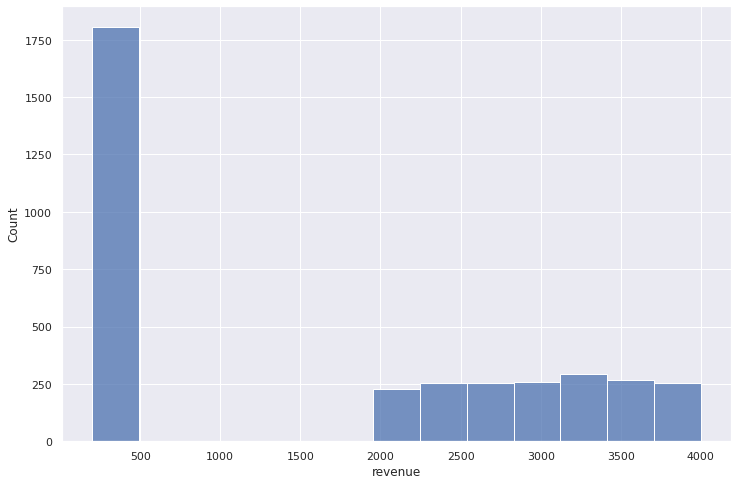

In [25]:
sns.histplot(paying_users[paying_users['revenue']<10000], x = 'revenue') 

Как видно из графика выше у нас имеется ассиметричное распредение при условии что мы убрали не платящих игроков и сильные выбросы. 

Слева в углу расположились игроки из группы А, справа из группы B. 

Теперь проверим на нормальность распределения критерием Шапиро-Уилка, где H0 - данные были взяты из нормального распределения.

Порог значения альфы беру равному 0.05.

In [26]:
data.revenue.quantile([0.999])

0.999    3675.231
Name: revenue, dtype: float64

Напишем функцию, которая меняет аномальные значения в группе А, на максимальное значение из группы B на 4000.

In [27]:
def control_revenue_change(revenue):
    if revenue > 4000:
        return 4000
    else:
        return revenue

In [28]:
data['control_revenue_changed'] = data['revenue'].apply(control_revenue_change)
paying_users['control_revenue_changed'] = paying_users['revenue'].apply(control_revenue_change)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


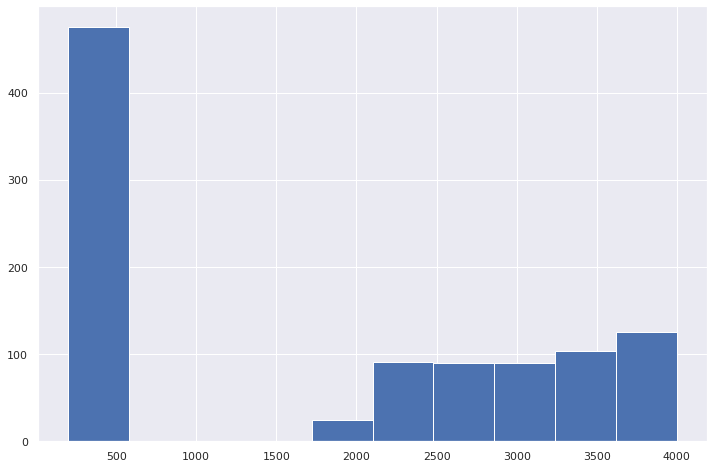

In [29]:
sample_changed_revenue = paying_users['control_revenue_changed'].sample(n=1000,random_state=25)

sample_changed_revenue.hist()

In [30]:
stats.shapiro(sample_changed_revenue)

ShapiroResult(statistic=0.8051872849464417, pvalue=4.9856855362540015e-33)

Из за того что у нас слишком много нулевых значений я взял revenue платящих игроков. При таком раскладе p-value меньше 0.05 и можно отвергать H0 о том что, данные были взяти из нормального распределения.

Теперь проверим гипотезу о равенстве дисперсий тестом Левена, которая проверяет H0 о том, что все входные выборки взяты из совокупностей с одинаковыми дисперсиями. Порогом альфы тоже 0.05

In [31]:
stats.levene(paying_users["control_revenue_changed"],paying_users["control_revenue_changed"])

LeveneResult(statistic=0.0, pvalue=1.0)

## A/B тестирование

Теперь перейдем к статистическому анализу нашего A/B тестирования. Условно возьмем цель увеличение revenue. 

Определим ключевые метрики оценки A/B тестирования. В нашем случае это: 

- ARPPU 
- Медианный чек

Критериями оценки возьмем:

- Непараметрический тест Манн-Уитни
- Bootstrap
- t-test

Порогом принятия альтернативной гипотезы будет альфа 0,05

Что насчет сильных выбросов группы А будем рассматривать оба варианта с выбросами и приравненнному к среднему значению revenue.

### Bootstrap
Функция Bootstrap  для проверки гипотезы, будем использовать медианное значение, потому что оно мы имеем сильные выбросы:

In [32]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Отберем группу платящих игроков, так как при сэмплировании всех игроков мы получаем нулевые значение во всех сэмплах, поэтому проверить всех игроков не представляется возможным

In [33]:
test_paying_users = gr_b.query('revenue > 0').revenue
control_paying_users = gr_a.query('revenue > 0').revenue

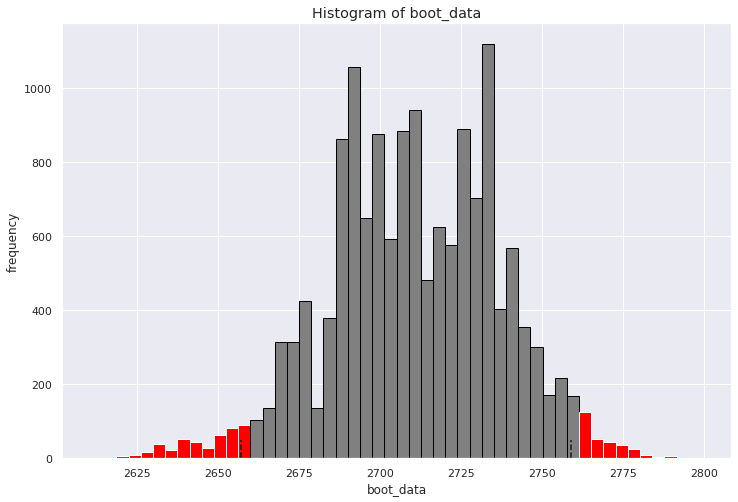

In [34]:
booted_data = get_bootstrap(test_paying_users, control_paying_users, boot_it = 15000, statistic = np.median) # в результате хранится разница двух распределений, ДИ и pvalue

In [35]:
booted_data["p_value"] 

0.0

In [36]:
booted_data["quants"] 

,0
0.025,2657.0
0.975,2759.0


#### Вывод: 

Проверка бутстрапирования данных показала, что мы обнаружили статистическое различие между группами платящими игроками. P-value равно 0.0. Таким образом мы можем опровергнуть нулевую гипотезу и принять альтернативную.

#### Mann-Whitneyu

Проверим два варианта: 

- Все игроки
- Только платящие игроки

In [37]:
test_revenue_array    = np.array(gr_b.revenue)
control_revenue_array = np.array(gr_a.revenue)

stats.mannwhitneyu(test_revenue_array,control_revenue_array, method = 'asymptotic')

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.06269701316074398)

In [38]:
stats.mannwhitneyu(test_paying_users,control_paying_users, method = 'asymptotic')

MannwhitneyuResult(statistic=3258025.0, pvalue=0.0)

#### Вывод

Для всех игроков критерий Манн-Уитни не обнаружил статистических различий и p-value равно 0.062, что не позволяет отклонить H0.
А среди платящих игроков мы получили p-value равное 0.0, и мы можем отклонить H0 и принять H1

### T-test

In [39]:
stats.ttest_ind(test_paying_users,control_paying_users)

Ttest_indResult(statistic=1.5917100176862002, pvalue=0.11153459157259504)

In [40]:
stats.ttest_ind(test_revenue_array,control_revenue_array)

Ttest_indResult(statistic=0.6242026493616787, pvalue=0.532494858971837)

#### Вывод 
Статистический t-test не показал стат различий между группами A/B, как с только платящими игроками так и совокупностью всех игроков 

## Общий вывод по A/B тестированию

Среди платящих игроков мы задетектили статистическое различие методом Bootstrap и Mann-Whitneyu, что позволяет нам принять альтернативную гипотезу о том, что revenue между группами не имеет различий. 

С другой стороны среди всех игроков мы не обнаружили статистических различий методом U-test и распределения между группами A/B не имеют различий. 

### Рекомендации

1) Все же думаю, лучше выкатить обновление и принять альтернативную гипотезу, так как целью было повысить revenue среди игроков, а не улучшить показатели конверсии в покупку. Хоть и в группе А имеются сильные выбросы мы не знаем наверняка откуда они и что они покупают, если оставить все как было мы становимся зависимы от таких рода игроков, поэтому лучше выбрать тестовый вариант, который не имеет игроков китов, но перформит себя стабильно

2) Проверить что за группа игроков китов в группе А их структуру, поведение, мотивацию

3) Если же такой сегмент китов есть и они готовы покупать по предложению контрольной группы, нужно предоставить им специальные предложения с такой же комплектацией и ценой, тогда возможно мы сможем удвоить наши результаты по revenue

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?



---

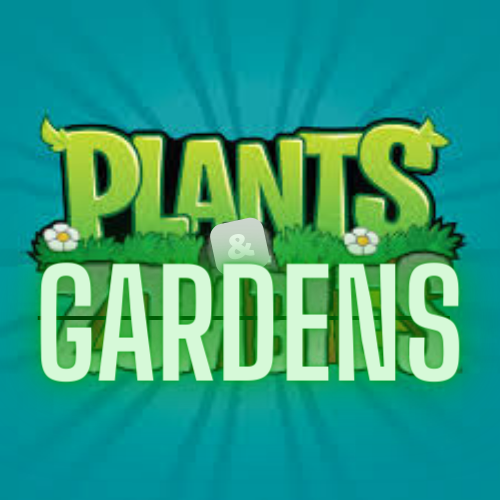

## Введение

Так как данной игры не существует, давайте дадим ему жизнь внутри проекта:

#### Title: Plants & Gardens
#### Publisher: Karpov.games
#### Genre: Match-3
#### Monetization: free-to-play (in-game purchases)

#### Описание:

_Решайте головоломки «три в ряд», чтобы вернуть прекрасному саду былую славу!_

_Отправляйтесь в приключенческое путешествие: проходите уровни «три в ряд», восстанавливайте и украшайте различные участки в саду, раскройте его секреты и наслаждайтесь компанией забавных игровых персонажей, включая Остина, вашего дворецкого! Чего ты ждешь? Постройте сад своей мечты!_

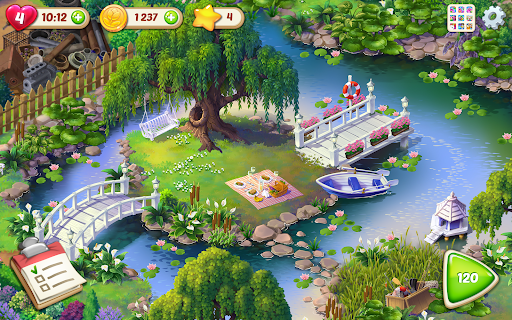 

Суть игры проходить -уровни паззлы match-3, пройди определенный уровень получи награду: игровые валюты, предметы, аксесуары для вашего сада, бонусы 

Будем считать, что событие это отдельные уровни от обычных в игре Plants & Gardens. 

## Цель 

Увеличение удержания и вовлеченности игроков в игре посредством введения ограниченного внутриигрового события. Другими словами, повышение лояльности наших игроков к Plants & Gardens.

### Метрики

**Ключевыми качественными метриками для оценки события X можно взять:**

- Retention rate
- Sessions + Average Session Duration
- Активность игроков 

**Количественные метрики:**

- Revenue 
- ARPU (Average revenue per user)
- ARPPU (Average revenue per paying user)
- LTV (Lifetime value) 
- Conversion rate в покупку

**Косвенными метрики качества:**

- Виральность k-фактор
- DAU, WAU, MAU
- Stickiness rate = DAU / MAU. Регулярность использования приложения в течение месяца. 


## Оценка качественных метрик

Главной оценочной успешности события для нас является, как по мне, Retention Rate (RR) — это коэффициент удержания клиентов. Самый простой способ его посчитать:

#### RR = количество клиентов в начале периода /(количество клиентов на конец периода−количество новых клиентов за период) * 100%

Он показывает сколько процентов игроков со дня начала события заново заходили в определенный день. Таким образом, данная метрика вполне отражает картину поведения игроков. Сравнивать можно с предыдущими периодами без ивентов и зафиксировать изменения с ивентом.

Другой метрикой можно использовать __Sessions + Average Session Duration__

Средняя продолжительность сессии (average session length, ASL) – среднее арифметическое длин всех сессий.

#### ASL= N/T

_T — суммарная продолжительность сессий за период_

_N — общее количество сессий за тот же период_

При повышении данной метрики мы можем сказать, что игроки начали больше играть в Plants & Gardens, чтобы получить уникальные предметы и др. бонусы.

Также можно сделать дополнить данную метрику сделав кастомную метрику Event s = Session in event / Session

Таким образом, если игрок находился при прохождении ивентовой части показатель будет равен 1, но учитывая что игрок также находится в главном меню и магазине, и др. функциональных частях игры, метрика будет находится, я думаю на уровне 0.8 в очень хорошем случае. 

Для более глубокого анализа ивента нужно следить за действиями и поведением игроков. Какие они целевые действия совершали, зашли ли они на ивент, винрейт уровней, процент получивших уникальный предмет и пр. Другими словами изучить логи игроков во время ивента.



## Оценка количественных метрик

Хоть и наш ивент направлен на улучшение лояльности игроков, все ровно не стоит забывать о показетеле Revenue, ARPU, ARPPU. Потому что данный ивент затрагивает баланс игровой валюты и бонусов. Если у игроков станет слишком много игровой валюты, бонусов на руках у них пропадет мотивацию их докупать за внутриигровые покупки. Поэтому не оставляем без внимания данную сторону бизнеса, все же Revenue один из самых ключевых показателей мобильной игры.

Показатели доходности могут вырасти из-за того что у игроков есть сильная мотивация пройти ивент и получить уникальные предметы. Чтобы успеть пройти уровни они могут пользоваться внутриигровыми бонусами таких как: дополнительная жизнь, ускорение, подсказки и.т.п. которыми можно запастись во внутриигровом магазине за деньги.

Немаловажно обратить внимание на показатели доходности нашей игры после ивента, так как может произойти такое что, у игроков будет, как я говорил ранее, слишком много игровой валюты у них пропадет мотивация донатить дополнительно, другими словами говоря "похмелье". Если такое случилось надо пересмотреть баланс игровой валюты на руках у игроков, оно должно быть только на достаточном уровне, не слишком много, не слишком мало.

## Оценка косвенных метрик

Косвенные метрики не дают оценить успешность нашего ивента, но могут помочь при анализе или дополнить наши ключевые метрики. В особенности Stickeness rate может дать оценку насколько наш ивент повысил "прилипчивость" к игре наших игроков. Если все юзеры будут заходить в игру каждый день коэфициент будет равен 1, но в реальности хорошее среднее месячное значение для всех жанров игр — 10-18%.

Если в игре есть функция "поделиться с друзьями" по тому или иному действию, тогда можно оценить успешность этой функции метриков K-фактор. 

**К−фактор=X⋅Y⋅Z**

X — процент пользователей, которые пригласили новых пользователей

Y — среднее число людей, которых пригласил единичный пользователь

Z — число пользователей, принявших приглашение

Чем больше K-фактор, тем стремительнее распространяется ваш продукт по сети и тем он более вирален, то есть нравится аудитории.

Ежедневный мониторинг показетелей вышеперечисленных метрик поможет нам оценивать результаты и прогресс нашего ивента. Важно сделать глубокий анализ после ивента собрать все данные и найти сильные и слабые стороны события в игре, чтобы улучшить его к следующему разу.

## Другое событие

При добавлении механики изменения событий, что при проигрыше игрок откатывается на несколько уровней назад, может не понравиться ему и вызвать негативные эмоции, которое даст мотивации просто закрыть игру. Поэтому у игрока должна быть мотивация сильнее проигрыша, другими словами награда за его старания должна быть соотвествующей, чтобы он раз за разом хотел пройти ивент. Чтобы игрок совсем не отчаивался после проигрышей, должна быть система "чекпоинтов" на определенном уровне, что не даст ему заново проходить все уровни. 

Данная механика может так и положительно повлиять на показатели, так и отрицательно. Успешность зависит от реализации дизайна уровней и награды от прохождения ивента. Если там действительно уникальная награда игрок может заново и заново проходить событие пока не получить желаемое, а чтобы проходить уровни он может тратить свои бустеры бонусы на сложных уровнях. Поэтому продажа бустеров, доп. жизней, бонусов может повыситься за этот счет. Но если награда не соответствует его оценочным стараниям, то тогда игрок просто не будет проходить ивент. 

Его старания должны окупаться по крайней мере в отношении вложенных его денег.

## Вывод 

Ежемесячные события в игре в мобильных играх на данный момент как нечто необходимое, так как в этой сфере наблюдается очень жесткая конкуренция. На 2020 год в Google Play доступно к скачиванию 2.96 миллионов приложений в App Store 4,4 млн приложений судя по статье на [VC.ru](https://vc.ru/marketing/245003-statistika-mobilnyh-prilozheniy-2021-zagruzki-trendy-i-dohodnost-industrii). Поэтому всегда есть другой другой аналог вашей же игры в этом жанре и чтобы игроки не ушли к конкурентом приходится всячески удерживать их тем или иным способом. 

В нашем же случае проведение ивентов может положительно сказываться на лояльности наших игроков. Чем больше лояльность к нашей игре, тем дольше они проживут в нашем проекте. Поэтому главной оценкой нашего ежемесячного события будет повышение лояльности пользователей к продукту. Чем больше больше игрок будет проводить время Plants&Gardens, тем больше будет вероятность его конверсии в покупку и малая доля просмотров рекламы. 